# A Simple Network in Keras

TensorFlow provides a wealth of functions to develop complex mathematical and machine learning programs.
In a sense, it is a powerful library for matrix (or tensor) manipulation with support for automatic
differentiation of functions.

However, using these more fundamental building blocks to develop complex deep neural networks is quite cumbersome.
To ease development and allow to focus on the actual machine learning model, TensorFlow supports two 
high level interfaces:
   * Keras
   * Estimators
   
Keras was originally developed by F. Chollet as an API specification for deep learning [Keras Project](https://keras.io/).
With version 2.0 of TensorFlow, Keras became one of the official and supported interfaces and is now
one of the main ways to use TensorFlow. Note that the "TensorFlow Keras" is maintained as ```tf.keras``` inside
TensorFlow which is different from the the "Keras Keras" from the Keras project. It is recommended to always
use ```tf.keras``` when using TensorFlow.

The [Estimator](https://www.tensorflow.org/guide/estimator) framework also provides a high level interface
to TensorFlow. This API is more geared towards production use in large clusters and code developed using ```tf.estimator```
can be deployed on a single machine or a cluster without change.

Keras is the "go-to" interface for more interactive model development and we will use this in the future.
Note that a Keras model can be converted to estimators via ```tf.keras.estimator.model_to_estimator(keras_model=model)``` 
so we do not lose anything by focusing on Keras.

The Keras API allow to define, train and use a deep neural network with a compact syntax.
The main steps are:


* Define the model
* Compile the model
* start the training with ```model.fit(...)```
* get the predictions with ```model.predict(...)```


This example will use the popular "iris" dataset.

The [Iris Dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) was [originally introduced](http://en.wikipedia.org/wiki/Iris_flower_data_set) by Sir Robert Fisher in 1936 as an example for discriminant analysis.
The data focus on how to discriminate between three different types of the [iris flower](http://en.wikipedia.org/wiki/Iris_(plant) ):

* Setosa, 
* Versicolour and
* Virginica

Each row in the dataset contains the following features (measured in cm):

* Sepal Length, 
* Sepal Width, 
* Petal Length and 
* Petal Width.

The labels (true values) are mapped as integers in $[0,1,2]$ for the three differerent flower types.

As this is a popular dataset, it is contained in various machine learning packages.
Here we use the data from the [SciKit-Learn](https://scikit-learn.org/stable/) machine learning suite.

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6
print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.1.0


As this is a popular training dataset, a convenient load function is provided to access it.

In [2]:
iris = load_iris()

### Exploratory Data Analysis

Let's first look at the data and understand it a bit better


In [3]:
#convert to a Pandas dataframe
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['target']=iris.target

In [4]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


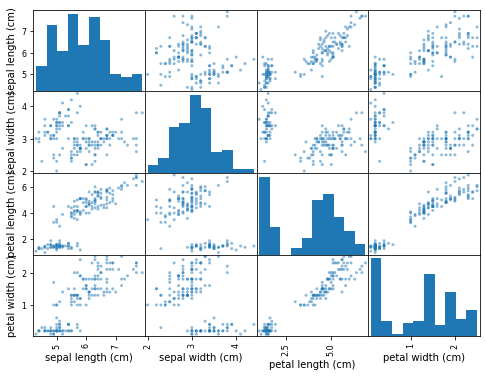

In [5]:
pd.plotting.scatter_matrix(iris_df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']])
plt.show()

Let's take a closer look at two of the variable in a scatter plot
and use color to highlight the label or target information.


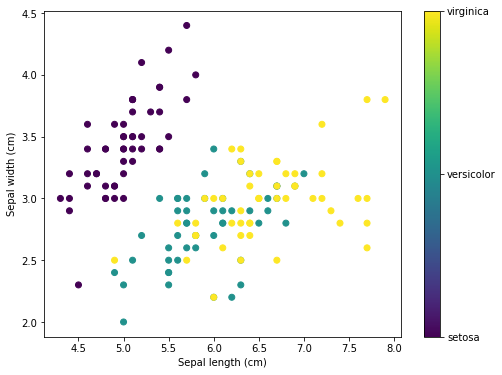

In [6]:
plt.scatter(iris_df['sepal length (cm)'], iris_df['sepal width (cm)'],c=iris.target)
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.show()

We can use [Andews Curves](https://en.wikipedia.org/wiki/Andrews_plot) to investigate how the features can be used to 
discriminate between the labels.

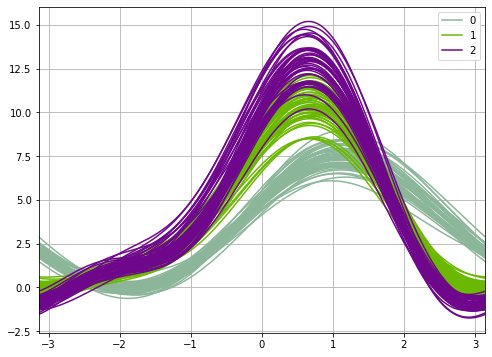

In [7]:
pd.plotting.andrews_curves(iris_df, 'target')
plt.show()

### Building a network in Keras

In this example we will use a very simple neural network.
The input layer has 4 nodes, correspondingn to the 4 feature variables in each row of the dataset.
The output layer has 3 nodes, corresponding to the 3 types of iris flowers we want to identify.

We then use two hidden layers with 10 nodes each - we could also use different settings, e.g. only one layer or more than two layers with different numbers of hidden nodes. The best setup depends on the problem we wish to analyse.

The main way to build models in Keras is to "stack" layers on top of each other, this is
done in the ```tf.keras.Sequential()``` model.

We will use ReLU as an activation function.
Note that we have specified the shape in the first network layer so the model knows what to expect
when we pass the data to it.

In [8]:
n_input = 4
n_output = 3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(n_input,)))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(n_output))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


We can also get a graphical representation of the model with its dependencies:

(note: this requires that the ```graphviz``` package is installed on the Linux system)

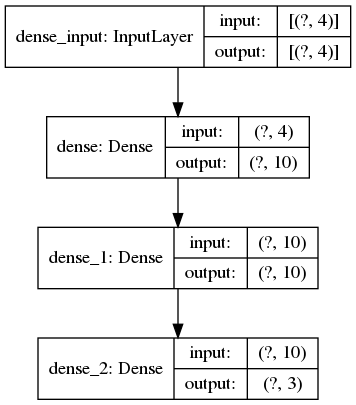

In [9]:
tf.keras.utils.plot_model(model, 'model.png',show_shapes=True)

Before we use the model we need to specify which optimizer and loss function the training process should use and which metrics should be evaluated.

The key concept behind Keras is that these details are determined beforehand when the model is "compiled" so that the training loop knows about them.

We need to define the following things:
* The loss function: This determines how the training process should evaluate whether the prediction made by the model is correct or not. As we have categorical data (three types of iris flowers) which we wish to classify, we use the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
* The optimizer. Several choices exist, as a good practice, the Adam Optimizer (See the [paper](https://arxiv.org/abs/1412.6980)
and the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) for more details) is a good starting point


In [10]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

The training process is then started by calling the ```fit``` method.
That's it - the convenience function ```fit``` hides all details for us.
The fit function returns a history object from which we can retrieve various training metrics.

In [11]:
history = model.fit(
        x=iris.data,
        y=iris.target,
        batch_size=32,
        epochs=50,
        verbose=1
    )

Train on 150 samples
Epoch 1/50
150/150 [==============================] - 1s 4ms/sample - loss: 1.2114 - sparse_categorical_accuracy: 0.4267
Epoch 2/50
150/150 [==============================] - 0s 93us/sample - loss: 0.9451 - sparse_categorical_accuracy: 0.3800
Epoch 3/50
150/150 [==============================] - 0s 141us/sample - loss: 0.8527 - sparse_categorical_accuracy: 0.5200
Epoch 4/50
150/150 [==============================] - 0s 134us/sample - loss: 0.7669 - sparse_categorical_accuracy: 0.9000
Epoch 5/50
150/150 [==============================] - 0s 84us/sample - loss: 0.6808 - sparse_categorical_accuracy: 0.6867
Epoch 6/50
150/150 [==============================] - 0s 193us/sample - loss: 0.6225 - sparse_categorical_accuracy: 0.6667
Epoch 7/50
150/150 [==============================] - 0s 166us/sample - loss: 0.5427 - sparse_categorical_accuracy: 0.8467
Epoch 8/50
150/150 [==============================] - 0s 899us/sample - loss: 0.4740 - sparse_categorical_accuracy: 0.9533

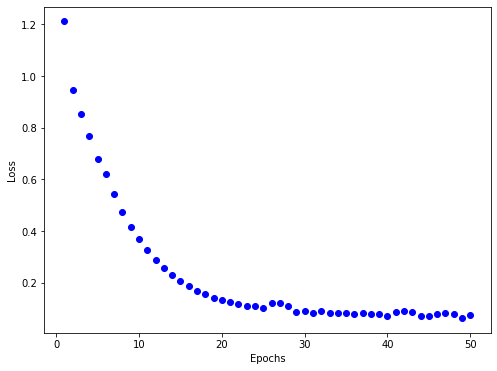

In [12]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

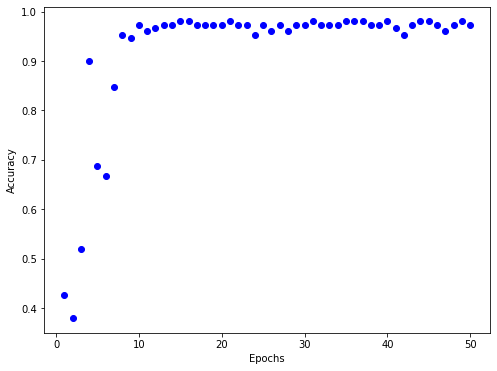

In [13]:
acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, acc_values, 'bo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

As we can see, the network does not improve much beyond training epoch 15 or so and reaches a plateau of approx.98% accuracy.
We can then use the ```predict()``` method to feed data to the trained model and obtain predictions for future or unknown data.

(As this is small dataset, we have not split between training and test data and also use the training data for 
evaluation. In a real project we would of course not do that...)

In [14]:
predictions=model.predict(iris.data)

Remember that we have three output nodes, each corresponding to one of the three label types (i.e. types of iris flowers).
We assign the predicted class as the one where the node in the output layer has the highest value.


For example, the first data point is:

In [15]:
print(predictions[0])

[ 15.937629   9.402544 -19.474049]


and the first node has the highest value. Hence we use '0' s the predicted label.

In [16]:
predicted_labels = tf.argmax(predictions, axis=1)
print("Prediction: {}".format(predicted_labels))
print("    Labels: {}".format(iris.target))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
    Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Since the dataset is so small, we can go through each prediction manually.
However, it is much easier to look at the confusion matrix, comparing
true and predicted labels.

[[50  0  0]
 [ 0 47  3]
 [ 0  0 50]]


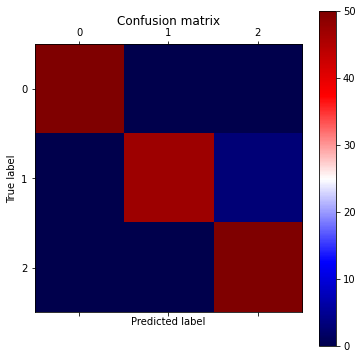

In [17]:
# Compute confusion matrix
cm = confusion_matrix(iris.target,predicted_labels)

print(cm)

# Show confusion matrix 
plt.matshow(cm, cmap='seismic')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()